In [17]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import numpy.random as rnd
import os
import sys
import re

import tensorflow as tf
from tensorflow import keras
import cv2
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import DataConversionWarning

# Ignore Warnings - obviously not a good choice
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=DataConversionWarning)

# Some Matplotlib magic
import matplotlib.pyplot as plt
%matplotlib inline

import pylab
pylab.rcParams["figure.figsize"] = 8, 6

In [2]:
os.listdir("./DATA")

['t10k-images-idx3-ubyte',
 'fashion-mnist_test.csv',
 't10k-labels-idx1-ubyte',
 'classification.ipynb',
 'train-images-idx3-ubyte',
 'fashion-mnist_train.csv',
 'train-labels-idx1-ubyte']

In [3]:
train, test = pd.read_csv(os.path.join("DATA", "fashion-mnist_train.csv")), \
              pd.read_csv(os.path.join("DATA", "fashion-mnist_test.csv"))

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def pandas_to_numpy_image(image):
    y = image[0]
    X = np.array(image[1:].as_matrix()).reshape((28, 28))
    return X, y

In [6]:
X_train, y_train = list(), list()
for iter, image in train.iterrows():
    X, y = pandas_to_numpy_image(image)
    X_train.append(X); y_train.append(y)
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = list(), list()
for iter, image in test.iterrows():
    X, y = pandas_to_numpy_image(image)
    X_test.append(X); y_test.append(y)
    
X_test, y_test = np.array(X_test), np.array(y_test)

### Visualisation

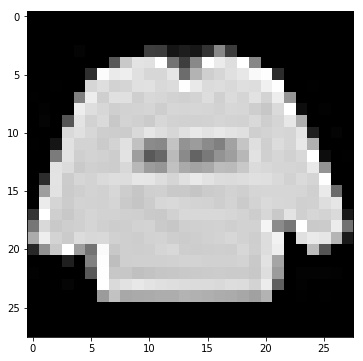

In [10]:
plt.imshow(X_train[0], cmap="gray", interpolation="nearest")

In [18]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

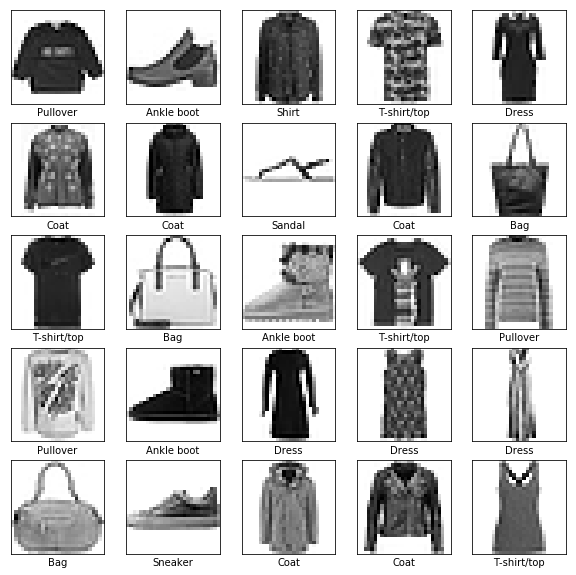

In [26]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Preprocessing

In [11]:
n_train = 60000
n_test = 10000
height = 28 
width = 28

In [15]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train.reshape(n_train * height * width).reshape((-1, 1)))
X_train = X_train.reshape((1, -1)).reshape((n_train, height, width))

X_test = scaler.transform(X_test.reshape(n_test * height * width).reshape((-1, 1)))
X_test = X_test.reshape((1, -1)).reshape((n_test, height, width))

## Building Model

#### Model overview:
* Convolutional Layer
* yet another Convolutional Layer
* Max Pooling Layer
* Flatten
* Dropout
* Hidden Feed-Forward Dense Layer - 32 Neurons
* Output Layer - 10 Labels

In [13]:
channels = 1
n_inputs = height * width

# Convolutional Layers
conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

# Max Pooling Layer
pool3_fmaps = conv2_fmaps

# Dense Layers
n_hidden4 = 64
n_outputs = 10

In [34]:
tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    X_reshaped = tf.reshape(X, shape=(-1, height, width, channels))
    y = tf.placeholder(tf.int32, shape=(None), name="y")
    
with tf.name_scope("convolutions"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                             strides=conv1_stride, padding=conv1_pad,
                             activation=tf.nn.relu, name="conv1d")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                             strides=conv2_stride, padding=conv2_pad,
                             activation=tf.nn.relu, name="conv2d")

with tf.name_scope("pooling"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
    
with tf.name_scope("droupout"):
    keep_prob = tf.placeholder_with_default(0.5, shape=(), name="keep_proba")
    droupout = tf.nn.dropout(pool3_flat, keep_prob=0.5)
    
with tf.name_scope("feed-forward"):
    hidden4 = tf.layers.dense(droupout, n_hidden4, activation=tf.nn.relu, name="hidden4")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(hidden4, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")
    
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

#### Setting up Logs

In [35]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")

if not os.path.exists("tf_logs"):
    os.mkdir("tf_logs")

root_logdir = "tf_logs"
logdir = os.path.join(
    root_logdir, "run-{}".format(now)
)

In [36]:
loss_summary = tf.summary.scalar("Loss", loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

## Training

In [37]:
X_train = X_train.astype(np.float32).reshape(-1, height * width)
X_test = X_test.astype(np.float32).reshape(-1, height * width)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [38]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [39]:
if not os.path.exists("./models"):
    os.mkdir("./models")

In [41]:
n_epochs = 10
batch_size = 100
n_batches = len(X_train) // batch_size
model_path = os.path.join("models", "model_one")
logs_path = os.path.join("tf_logs", "")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index, (X_batch, y_batch) in enumerate(shuffle_batch(X_train, y_train, batch_size)):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if batch_index % 10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch #{} Test accuracy: {}".format(epoch, acc_test))
        
        save_path = saver.save(sess, model_path)

## Simpler model with Keras

In [28]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

In [29]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 23s 385us/step - loss: 0.5043 - acc: 0.8217
Epoch 2/10
60000/60000 [==============================] - 21s 351us/step - loss: 0.3781 - acc: 0.8645
Epoch 3/10
60000/60000 [==============================] - 23s 379us/step - loss: 0.3420 - acc: 0.8759
Epoch 4/10
60000/60000 [==============================] - 23s 381us/step - loss: 0.3151 - acc: 0.8863
Epoch 5/10
60000/60000 [==============================] - 21s 345us/step - loss: 0.2980 - acc: 0.8910
Epoch 6/10
60000/60000 [==============================] - 20s 338us/step - loss: 0.2852 - acc: 0.8952
Epoch 7/10
60000/60000 [==============================] - 20s 338us/step - loss: 0.2719 - acc: 0.8989
Epoch 8/10
60000/60000 [==============================] - 20s 339us/step - loss: 0.2626 - acc: 0.9022
Epoch 9/10
60000/60000 [==============================] - 21s 342us/step - loss: 0.2532 - acc: 0.9052
Epoch 10/10
60000/60000 [==============================] - 21s 346us/step - loss: 

In [33]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [34]:
test_acc

0.8851

In [38]:
predictions = model.predict(X_test)

In [44]:
np.argmax(predictions[0])

0